# Smart Farming: IoT-Based Disease Detection for Plants

### Models Used:
- ResNet50
- InceptionV3
- VGG16
- MobileNet
- EfficientNet-B0
- MobileNetV3-Large-100


##  Import necessary libraries

In [ ]:
# Install ptflops (run once)
!pip install ptflops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [ ]:
#  System & Utilities
import os
import random
import warnings
from pathlib import Path
from tqdm import tqdm

warnings.filterwarnings('ignore')

#  Data Handling & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten,
    BatchNormalization, Dropout, GlobalAveragePooling2D, Lambda, Rescaling
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16, MobileNet
from tensorflow.keras import mixed_precision
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

#  Evaluation Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#  Other
import timm
import kagglehub
import torch


## Download & Prepare Dataset

In [ ]:
# Step 1: Download dataset using kagglehub
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
dataset_dir = Path(path)

# Step 2: Identify the nested "New Plant Diseases Dataset(Augmented)" folder
first_level_folder = dataset_dir / "New Plant Diseases Dataset(Augmented)"
second_level_folder = first_level_folder / "New Plant Diseases Dataset(Augmented)"  # The nested folder

# Step 3: Define correct paths
train_dir = second_level_folder / "train"
val_dir = second_level_folder / "valid"
test_dir = dataset_dir / "test" / "test"

# Step 4: Verify that paths exist
print(f"Train Directory Path: {train_dir}")
print(f"Validation Directory Path: {val_dir}")
print(f"Test Directory Path: {test_dir}")

print(f"Train directory exists: {train_dir.exists()}")
print(f"Validation directory exists: {val_dir.exists()}")
print(f"Test directory exists: {test_dir.exists()}")

# Step 5: Load Training Data Safely
if train_dir.exists():
    filenames_train = []
    label_train = []

    folds = os.listdir(train_dir)  # List all class folders
    for fold in tqdm(folds, desc="Processing Classes"):
        FoldPath = os.path.join(train_dir, fold)

        if os.path.isdir(FoldPath):  # Ensure it's a directory
            files = os.listdir(FoldPath)
            for file in files:
                filepath = os.path.join(FoldPath, file)
                filenames_train.append(filepath)
                label_train.append(fold)

    print(f"Total Training Images: {len(filenames_train)}")
else:
    print("No training data found. Check dataset structure.")

# Step 6: Load Validation Data Safely
if val_dir.exists():
    filenames_val = []
    label_val = []

    folds = os.listdir(val_dir)  # List all class folders
    for fold in tqdm(folds, desc="Processing Validation Classes"):
        FoldPath = os.path.join(val_dir, fold)

        if os.path.isdir(FoldPath):  # Ensure it's a directory
            files = os.listdir(FoldPath)
            for file in files:
                filepath = os.path.join(FoldPath, file)
                filenames_val.append(filepath)
                label_val.append(fold)

    print(f"Total Validation Images: {len(filenames_val)}")
else:
    print("No validation data found. Check dataset structure.")

# Step 7: Count Test Data
if test_dir.exists():
    total_test = len([f for f in test_dir.iterdir() if f.is_file()])
    print(f"Total Test Images: {total_test}")
else:
    print("No test data found.")


Train Directory Path: /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
Validation Directory Path: /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid
Test Directory Path: /kaggle/input/new-plant-diseases-dataset/test/test
Train directory exists: True
Validation directory exists: True
Test directory exists: True


Processing Classes: 100%|██████████| 38/38 [00:02<00:00, 17.39it/s]


Total Training Images: 70295


Processing Validation Classes: 100%|██████████| 38/38 [00:01<00:00, 31.32it/s]

Total Validation Images: 17572
Total Test Images: 33


In [ ]:
path = Path(path)

actual_dataset_folder = path / "New Plant Diseases Dataset(Augmented)" / "New Plant Diseases Dataset(Augmented)"  # Adjusted for nested structure

train_dir = actual_dataset_folder / "train"
val_dir = actual_dataset_folder / "valid"
test_dir = path / "test" / "test"  # Adjusted to use path directly

# Print paths
print(f"Train Directory : {train_dir}")
print(f"Validation Directory : {val_dir}")
print(f"Test Directory : {test_dir}")


Train Directory : /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
Validation Directory : /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid
Test Directory : /kaggle/input/new-plant-diseases-dataset/test/test


In [ ]:
total_class_train = len(os.listdir(train_dir))
total_class_val = len(os.listdir(val_dir))
total_test = len(os.listdir(test_dir))

print(f"Total of Train Data Classes: {total_class_train} classes")
print(f"Total of Validation Data Classes: {total_class_val} classes")
print(f"Total of Test Data: {total_test} images")

Total of Train Data Classes: 38 classes
Total of Validation Data Classes: 38 classes
Total of Test Data: 33 images


In [ ]:
def count_data_per_class(path):
    classes = sorted(os.listdir(path))
    class_counts = {}
    for cls in classes:
        class_path = os.path.join(path, cls)
        class_counts[cls] = len(os.listdir(class_path))
    return class_counts

train_class_counts = count_data_per_class(train_dir)
val_class_counts = count_data_per_class(val_dir)

train_counts_df = pd.DataFrame.from_dict(train_class_counts, orient="index", columns=["Count"])
val_counts_df = pd.DataFrame.from_dict(val_class_counts, orient="index", columns=["Count"])

print(f"Total Image for Training: {sum(train_class_counts.values())} images")
print(f"Total Image for Validation: {sum(val_class_counts.values())} images")

Total Image for Training: 70295 images
Total Image for Validation: 17572 images


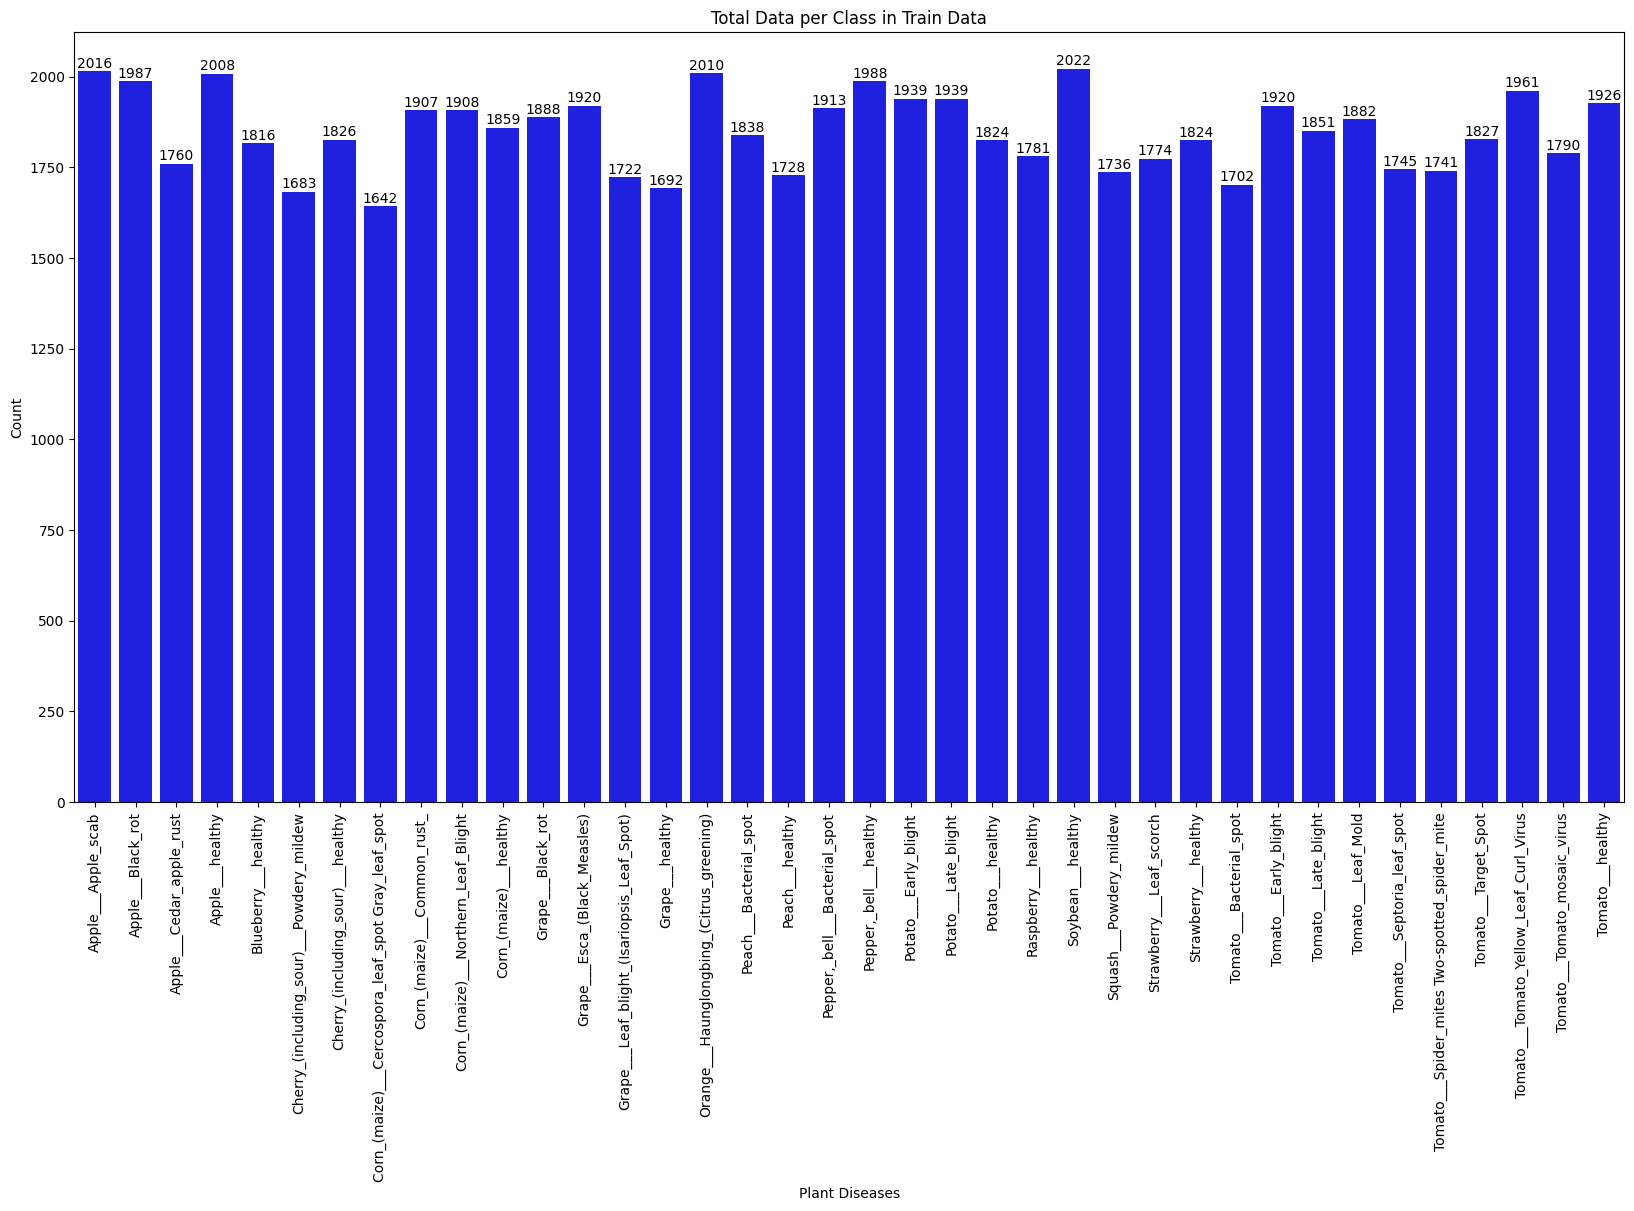

In [ ]:
# Plot total data per class for training data
plt.figure(figsize=(20, 10))
sns.barplot(data=train_counts_df, x=train_counts_df.index, y="Count", color="blue")
plt.title("Total Data per Class in Train Data")
plt.xlabel("Plant Diseases")
plt.ylabel("Count")
plt.xticks(rotation=90)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height() + 10,
            '{:1.0f}'.format(p.get_height()), ha="center")
plt.savefig("Total Data per Class in Train Data.jpg")
plt.show()

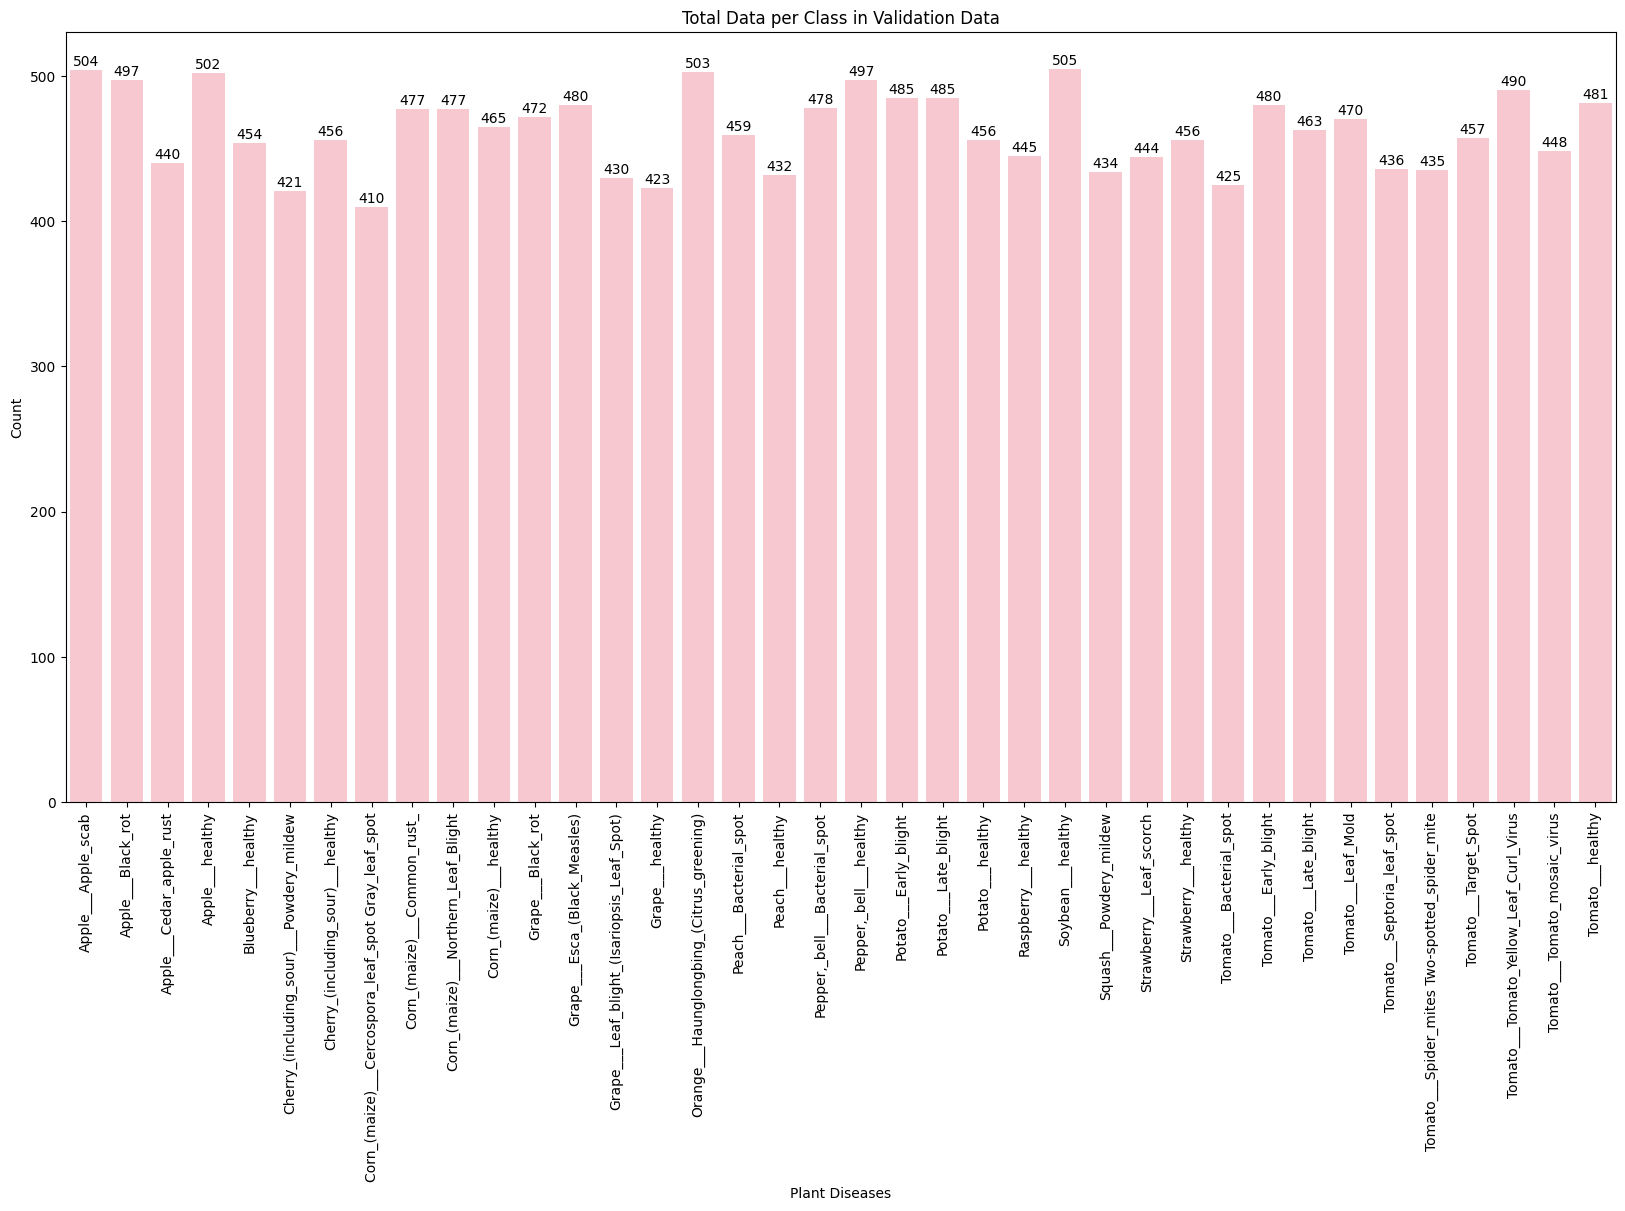

In [ ]:
# Plot total data per class for validation data
plt.figure(figsize=(20, 10))
sns.barplot(data=val_counts_df, x=val_counts_df.index, y="Count", color="pink")
plt.title("Total Data per Class in Validation Data")
plt.xlabel("Plant Diseases")
plt.ylabel("Count")
plt.xticks(rotation=90)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height() + 3,
            '{:1.0f}'.format(p.get_height()), ha="center")
plt.savefig("Total Data per Class in Validation Data.jpg")
plt.show()

In [ ]:
all_diseases = sorted(os.listdir(train_dir))
plants = []
for cls in all_diseases:
    plant = cls.split("___")[0]
    if plant not in plants:
        plants.append(plant)

num_plants = len(plants)
print(f"Number of Plants: {num_plants} plants")
print("Kind of Plants: ")
for i, plant in enumerate(plants):
    print(f"{i+1}. {plant}")

Number of Plants: 14 plants
Kind of Plants: 
1. Apple
2. Blueberry
3. Cherry_(including_sour)
4. Corn_(maize)
5. Grape
6. Orange
7. Peach
8. Pepper,_bell
9. Potato
10. Raspberry
11. Soybean
12. Squash
13. Strawberry
14. Tomato


In [ ]:
diseases = []
for cls in all_diseases:
    disease = cls.split("___")[1]
    if disease not in diseases:
        if disease != "healthy":
            diseases.append(disease)
num_diseases = len(diseases)
print(f"\nNumber of Diseases: {num_diseases} diseases")
print("Kind of Diseases: ")
for i, disease in enumerate(diseases):
    print(f"{i+1}. {disease}")


Number of Diseases: 20 diseases
Kind of Diseases: 
1. Apple_scab
2. Black_rot
3. Cedar_apple_rust
4. Powdery_mildew
5. Cercospora_leaf_spot Gray_leaf_spot
6. Common_rust_
7. Northern_Leaf_Blight
8. Esca_(Black_Measles)
9. Leaf_blight_(Isariopsis_Leaf_Spot)
10. Haunglongbing_(Citrus_greening)
11. Bacterial_spot
12. Early_blight
13. Late_blight
14. Leaf_scorch
15. Leaf_Mold
16. Septoria_leaf_spot
17. Spider_mites Two-spotted_spider_mite
18. Target_Spot
19. Tomato_Yellow_Leaf_Curl_Virus
20. Tomato_mosaic_virus


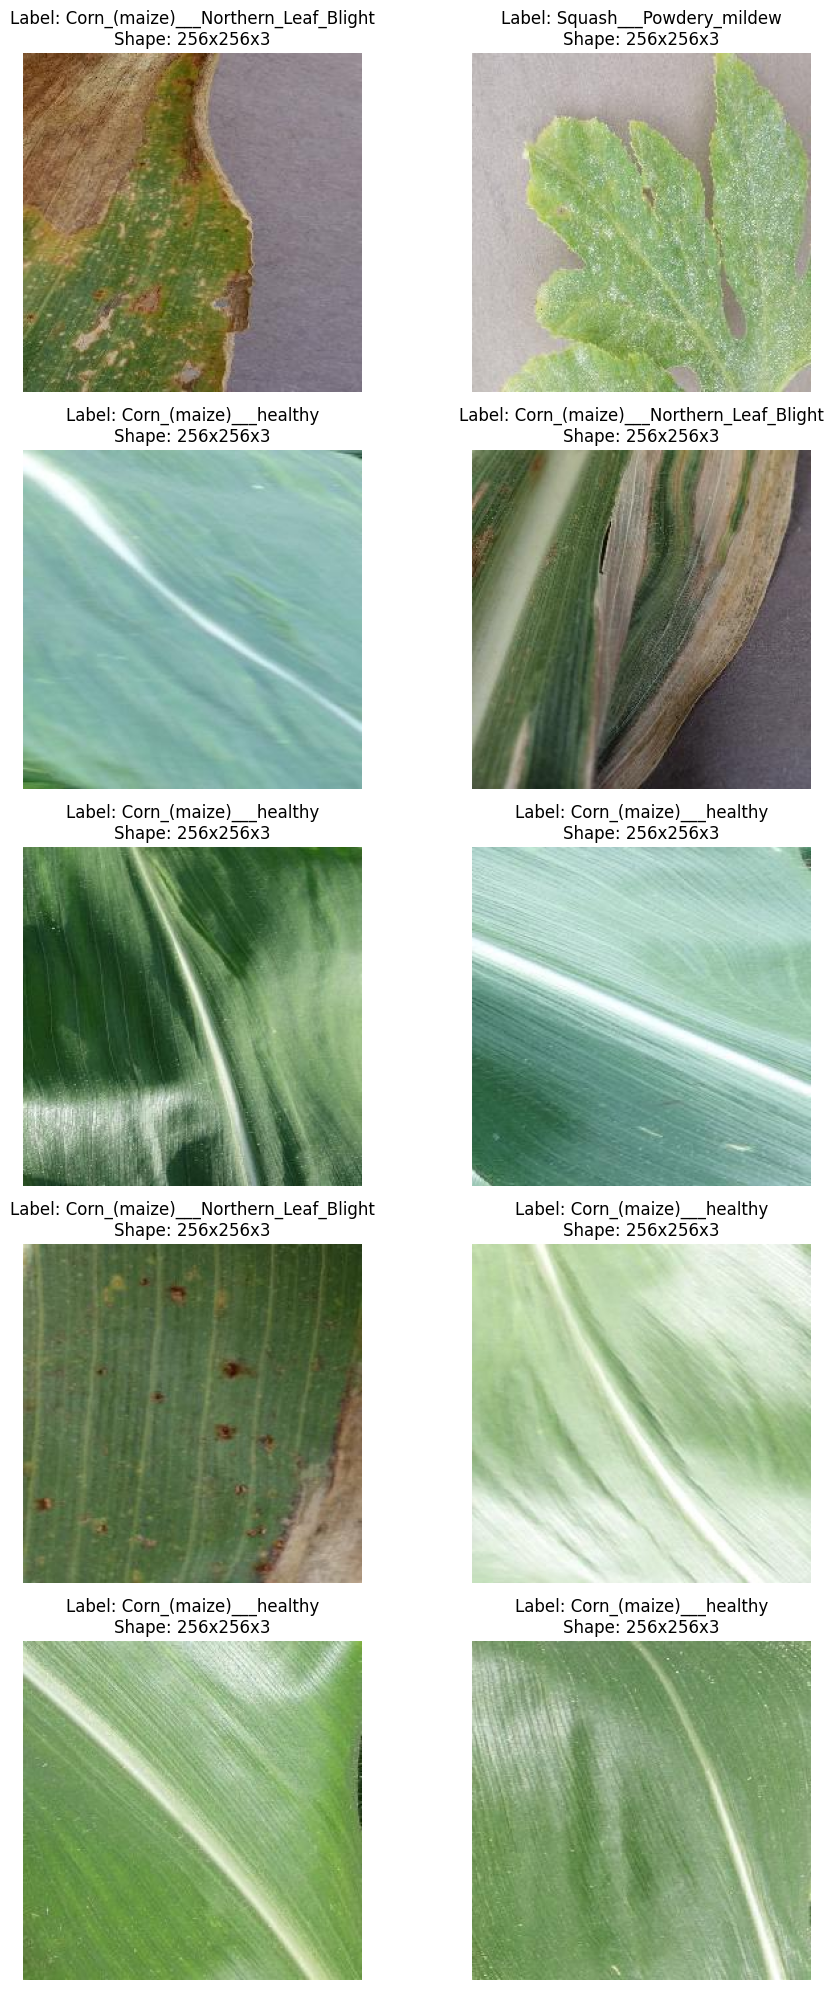

In [ ]:
# Display 10 random images with labels and shapes
image_path_list = list(dataset_dir.glob("*/*/*/*/*.jpg"))  # Changed glob pattern to search deeper

# Check if image_path_list is empty before sampling
if not image_path_list:
    print("No images found with the specified pattern. Check your dataset structure.")
else:
    # If images are found, proceed with sampling and display
    random_image_paths = random.sample(image_path_list, min(len(image_path_list), 10))
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
    for i, ax in enumerate(axes.flat):
        random_image_path = random_image_paths[i]  # Get image path
        image_class = random_image_path.parent.stem  # Get image class from directory name
        image = Image.open(random_image_path)  # Open image
        ax.imshow(image)  # Display image on subplot
        # Add label and shape of the image
        ax.set_title(f"Label: {image_class}\nShape: {image.height}x{image.width}x{3 if image.mode=='RGB' else 1}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
SEED = 42  # or any number you choose

# 1. Python built-in random
random.seed(SEED)

# 2. NumPy
np.random.seed(SEED)

# 3. TensorFlow/Keras
tf.random.set_seed(SEED)

# 4. PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU

# 5. Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(SEED)

In [ ]:

# Data Transformations & Dataset Creation using TensorFlow

# Define parameters
BatchSize = 32
width, height = 224, 224

# Option for using only a subset of data (e.g. 10% of the total)
#data_percentage = 0.1  # Change to 0.2 for 20%, 1.0 for 100% etc.
data_percentage = 1.0


# Create full training and validation datasets using image_dataset_from_directory
train_dataset_full = tf.keras.preprocessing.image_dataset_from_directory(
    directory=str(train_dir),
    labels="inferred",
    label_mode="categorical",
    batch_size=BatchSize,
    image_size=(width, height),
    shuffle=True,
    seed= SEED
)

val_dataset_full = tf.keras.preprocessing.image_dataset_from_directory(
    directory=str(val_dir),
    labels="inferred",
    label_mode="categorical",
    batch_size=BatchSize,
    image_size=(width, height),
    shuffle=True,
    seed= SEED
)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [ ]:
# Determine the number of batches in each full dataset
num_train_batches = tf.data.experimental.cardinality(train_dataset_full).numpy()
num_val_batches = tf.data.experimental.cardinality(val_dataset_full).numpy()

# Calculate the new number of batches to use based on data_percentage
train_steps = int(num_train_batches * data_percentage)
val_steps = int(num_val_batches * data_percentage)

# Use .take() to create the subset datasets
train_dataset = train_dataset_full.take(train_steps)
val_dataset = val_dataset_full.take(val_steps)

print(f"Using {train_steps * BatchSize} training images and {val_steps * BatchSize} validation images.")

Using 70304 training images and 17600 validation images.


In [ ]:
# Get class names from the full training dataset
class_names = train_dataset_full.class_names  # e.g., ['Apple___Apple_scab', 'Apple___Black_rot', ...]
num_classes = len(class_names)

# Create a lookup table mapping class names to integer indices
lookup_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(class_names),
        values=tf.constant(list(range(num_classes)), dtype=tf.int64)
    ),
    default_value=-1
)

def process_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [width, height])
    img = img / 255.0
    return img

def get_label(file_path):
    # Split the path by os.sep and get the second-to-last part as the label
    parts = tf.strings.split(file_path, os.sep)
    label_str = parts[-2]
    # Lookup the integer label using the lookup table
    label_index = lookup_table.lookup(label_str)
    # One-hot encode the label
    return tf.one_hot(label_index, depth=num_classes)

# List test files (assuming test images are directly under test_dir)
test_files = tf.data.Dataset.list_files(str(test_dir / '*.[Jj][Pp][Gg]'), shuffle=False)

# Map processing functions to get (image, label) tuples, then batch the dataset
test_dataset = test_files.map(lambda x: (process_image(x), get_label(x)))
test_dataset = test_dataset.batch(BatchSize)

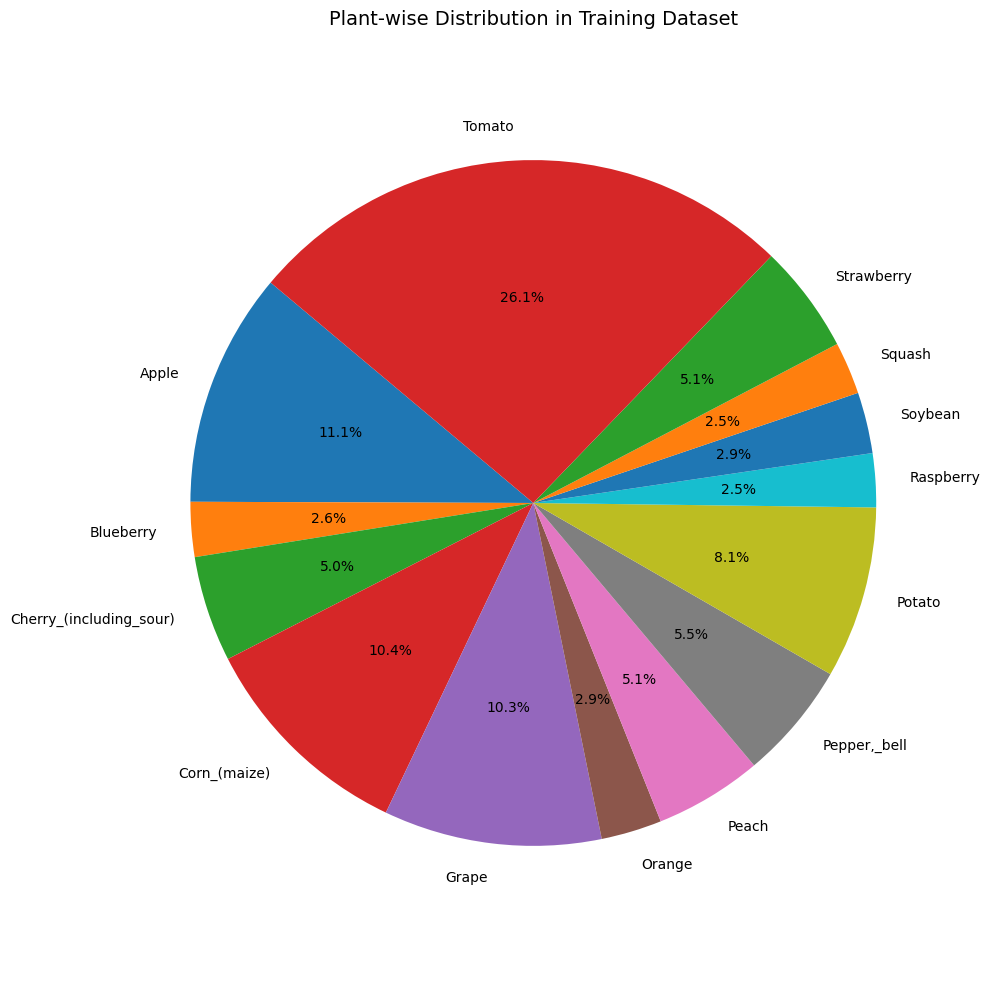

In [ ]:
from collections import defaultdict

plant_counts = defaultdict(int)
for cls, count in train_class_counts.items():
    plant = cls.split("___")[0]
    plant_counts[plant] += count

plt.figure(figsize=(10, 10))
plt.pie(plant_counts.values(), labels=plant_counts.keys(), autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
plt.title("Plant-wise Distribution in Training Dataset", fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()


# RESNET50

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

seed = SEED

# Apply ResNet50 preprocessing to datasets
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset_full.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)
val_dataset = val_dataset_full.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)

# Build the model
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze base model

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(38, activation='softmax')(x)  # 38 classes
model_resnet = models.Model(inputs, outputs)

model_resnet.summary()

#GFLOPs calculation
# Function to calculate FLOPs
def get_flops(model, input_shape=(1, 224, 224, 3)):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(tf.TensorSpec(input_shape, model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)

    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

        flops = tf.compat.v1.profiler.profile(
            graph=graph,
            run_meta=run_meta,
            cmd='op',
            options=opts
        )

        return flops.total_float_ops


flops = get_flops(model_resnet)
gflops = flops / 1e9
print(f"GFLOPs: {gflops:.2f}")


# Compile the model
model_resnet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
es = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', verbose=1)
mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
lr = ReduceLROnPlateau(monitor='val_accuracy', patience=5, min_lr=1e-5, verbose=1)


# Train
history_resnet = model_resnet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=17,
    steps_per_epoch=300,
    verbose=True,
    callbacks=[es, mc, lr]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        77,862 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,665,574 (90.28 MB)

 Trainable params: 77,862 (304.15 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


GFLOPs: 7.75
Epoch 1/17
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6587 - loss: 1.4400
Epoch 1: val_accuracy improved from -inf to 0.93564, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 86s 246ms/step - accuracy: 0.6593 - loss: 1.4376 - val_accuracy: 0.9356 - val_loss: 0.2681 - learning_rate: 0.0010
Epoch 2/17
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9376 - loss: 0.2457
Epoch 2: val_accuracy improved from 0.93564 to 0.95567, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 71s 236ms/step - accuracy: 0.9376 - loss: 0.2456 - val_accuracy: 0.9557 - val_loss: 0.1719 - learning_rate: 0.0010
Epoch 3/17
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9514 - loss: 0.1771
Epoch 3: val_accuracy improved from 0.95567 to 0.96352, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 71s 236ms/step - accuracy: 0.9515 - loss: 0.1771 - val_accuracy: 0.9635 - val_loss: 0.1369 - learning_rate: 0.0010
Epoch 4/17
300/300 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

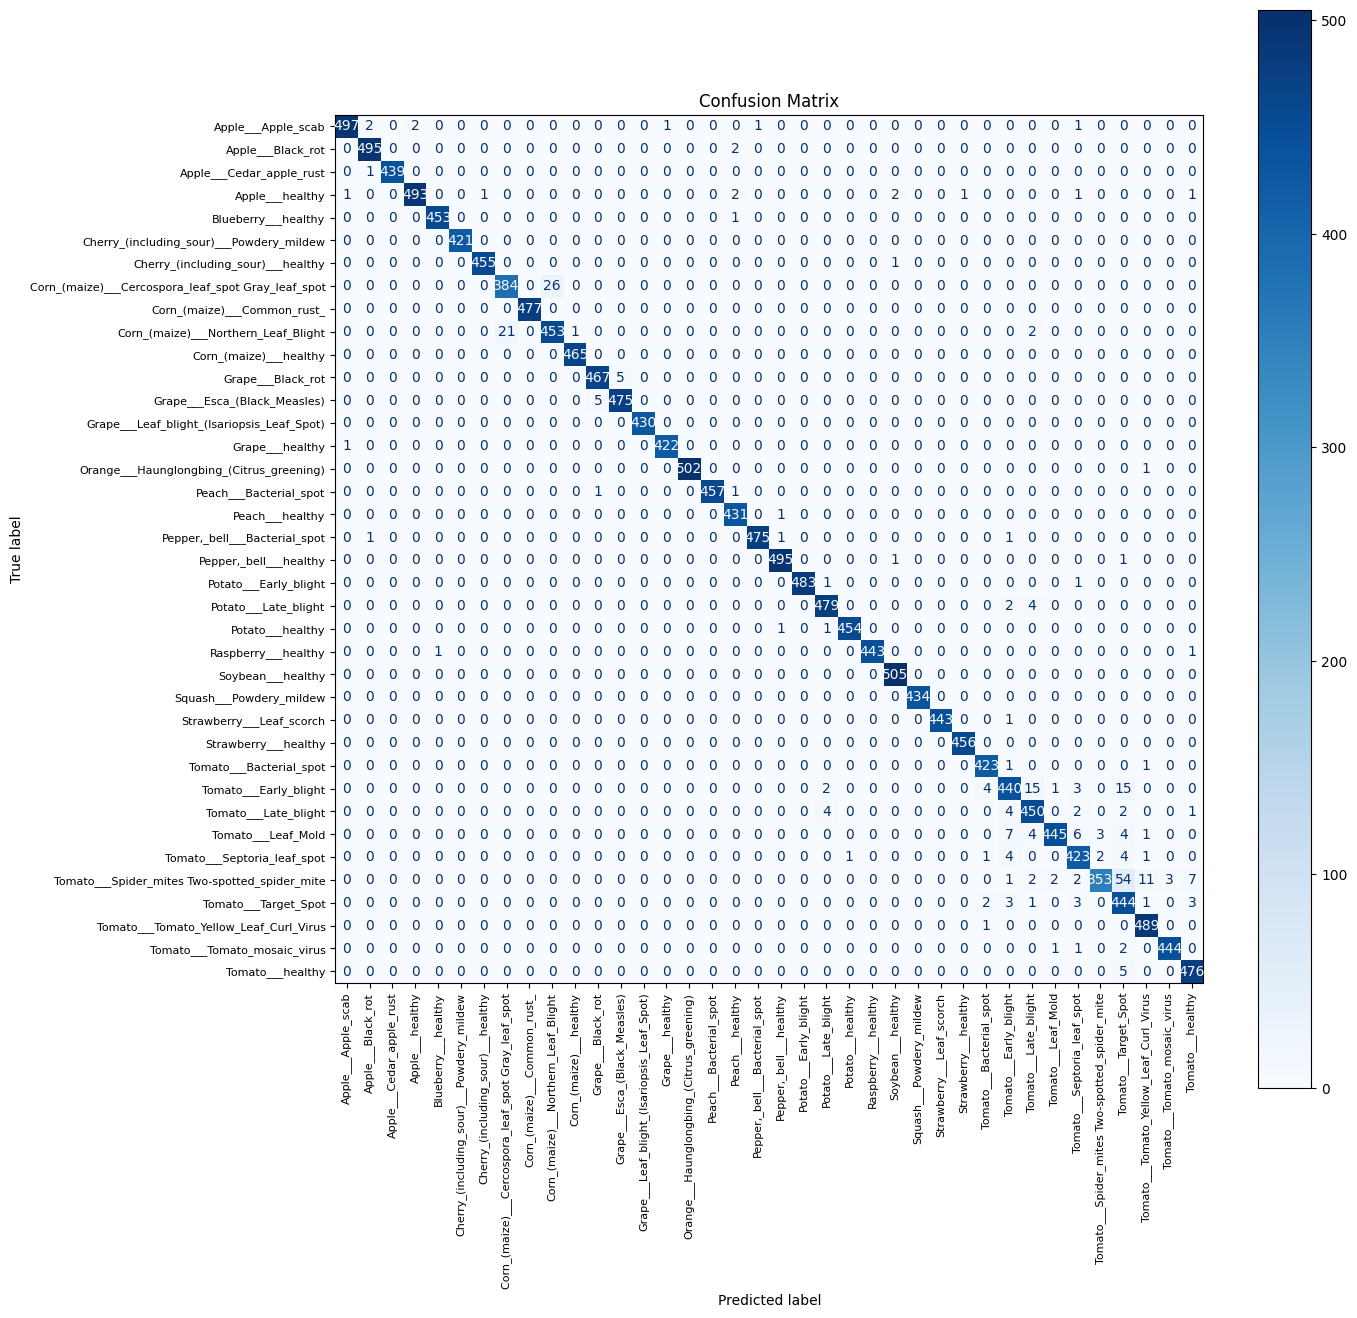

Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.99      0.99       504
                                 Apple___Black_rot       0.99      1.00      0.99       497
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       440
                                   Apple___healthy       1.00      0.98      0.99       502
                               Blueberry___healthy       1.00      1.00      1.00       454
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.94      0.94       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
               Corn_(maize)___Northern_Leaf_Blight     

In [ ]:
# Get class names from the validation dataset
class_names = val_dataset_full.class_names

# Preprocess val_dataset_full for evaluation
val_dataset_full_processed = val_dataset_full.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)

# Collect true and predicted labels
y_true = []
y_pred = []

# Use the preprocessed dataset for prediction
for images, labels in val_dataset_full_processed:
    preds = model_resnet.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Generate and display the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Create the figure and axes with the desired size before calling disp.plot()
fig, ax = plt.subplots(figsize=(14, 14))

# Pass the axes to disp.plot() using the ax keyword argument
disp.plot(
    xticks_rotation=90,
    cmap='Blues',
    ax=ax  # Pass the axes to disp.plot()
)

plt.title("Confusion Matrix")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

#  Print classification report with precision, recall, f1-score, and support
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)


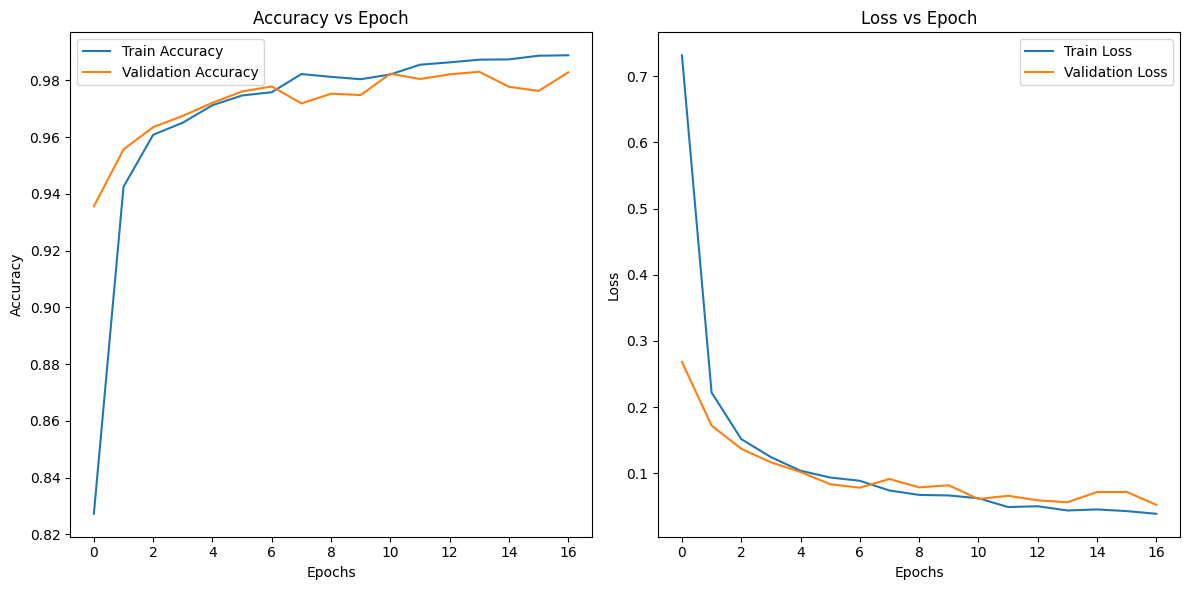

In [ ]:
# Accessing the history of accuracy and loss from the history_resnet variable
train_loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
train_accuracy = history_resnet.history['accuracy']
val_accuracy = history_resnet.history['val_accuracy']

# Plotting accuracy vs. loss
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


# VGG_16

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ lambda[0][0]      │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ lambda[0][0]      │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 38)        │     19,494 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,734,182 (56.21 MB)

 Trainable params: 19,494 (76.15 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


GFLOPs: 30.71
Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.3451 - loss: 3.3236
Epoch 1: val_accuracy improved from -inf to 0.80446, saving model to /content/best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 176s 540ms/step - accuracy: 0.3458 - loss: 3.3186 - val_accuracy: 0.8045 - val_loss: 0.6665 - learning_rate: 0.0010
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8336 - loss: 0.5613
Epoch 2: val_accuracy improved from 0.80446 to 0.88362, saving model to /content/best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 155s 519ms/step - accuracy: 0.8337 - loss: 0.5611 - val_accuracy: 0.8836 - val_loss: 0.3903 - learning_rate: 0.0010
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8926 - loss: 0.3652
Epoch 3: val_accuracy improved from 0.88362 to 0.91173, saving model to /content/best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 156s 520ms/step - accuracy: 0.8927 - loss: 0.3651 - val_accuracy: 0.9117 - val_loss: 0.2948 - learning_rate: 0.0

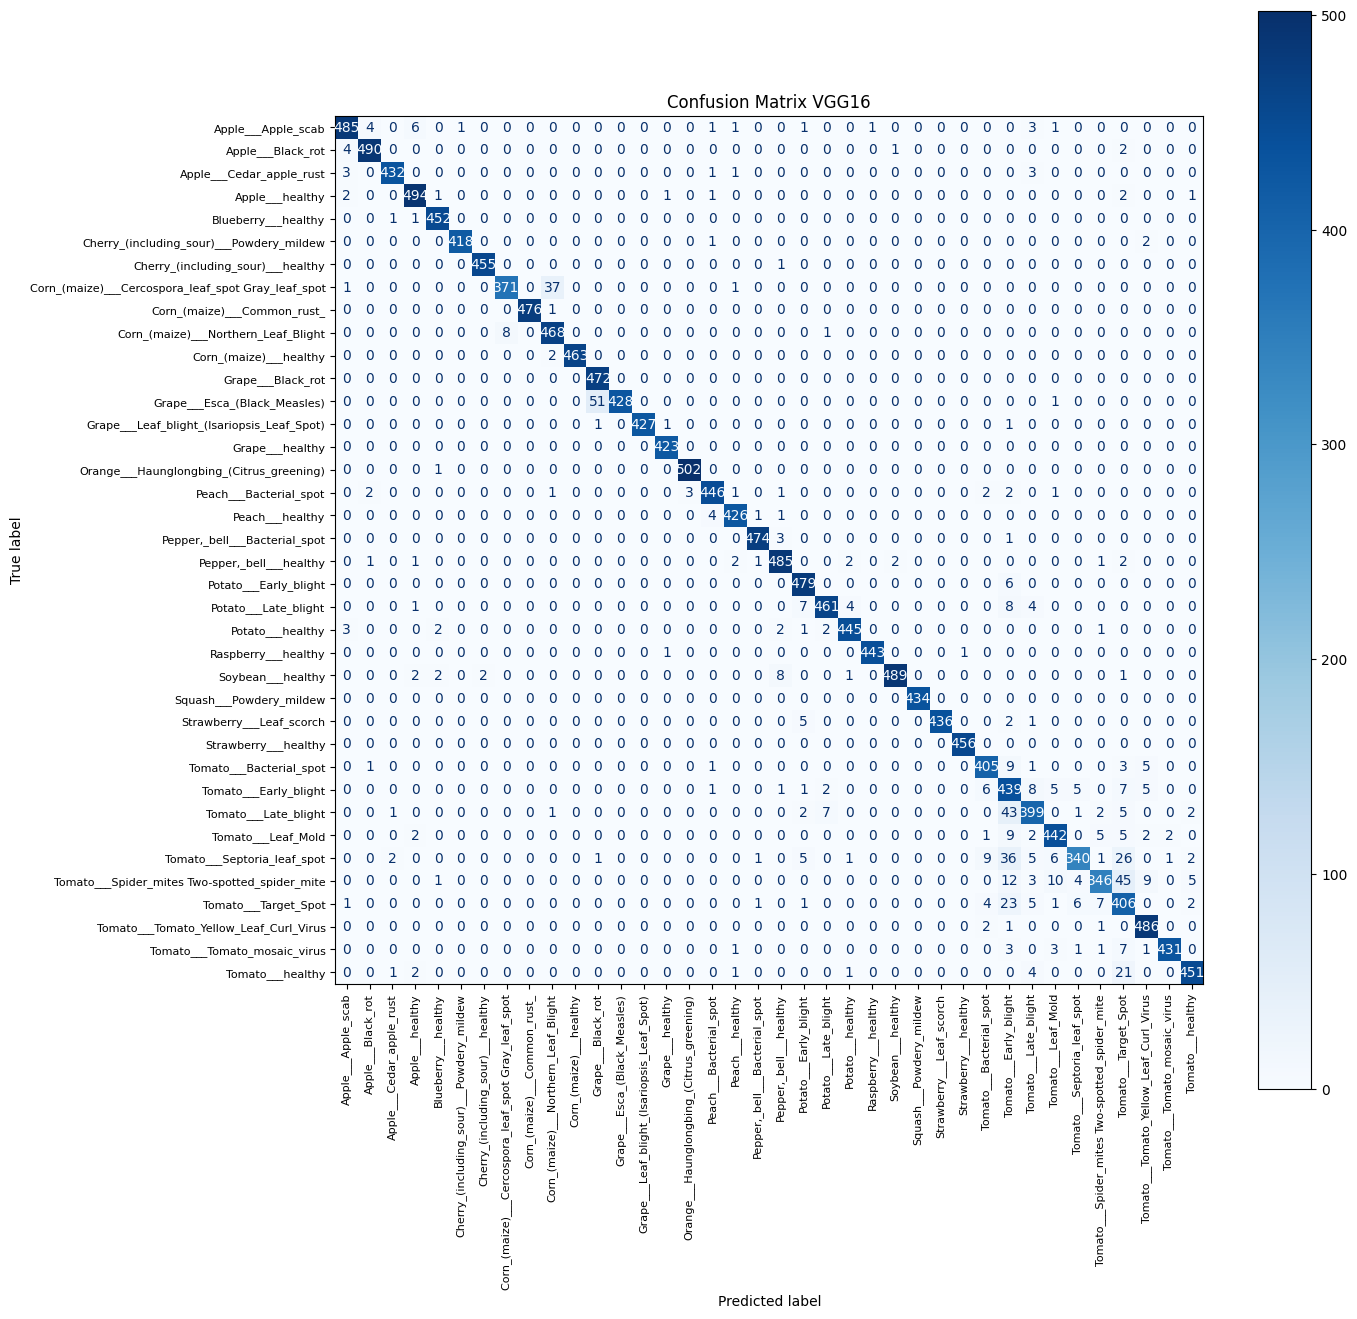

Classification Report for VGG16 Model:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.96      0.97       504
                                 Apple___Black_rot       0.98      0.99      0.98       497
                          Apple___Cedar_apple_rust       0.99      0.98      0.99       440
                                   Apple___healthy       0.97      0.98      0.98       502
                               Blueberry___healthy       0.98      1.00      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      1.00       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.90      0.94       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
               Corn_(maize)___Northern_

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

seed= SEED

# Load base model
base_model_tf_minimal = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model_tf_minimal.trainable = False  # freeze base

# Input & preprocessing
pt_minimal = Input(shape=(224, 224, 3))
func_minimal = Lambda(lambda x: tf.cast(x, tf.float32))(pt_minimal)
x_minimal = preprocess_input(func_minimal)

# Add minimal classifier head (no middle layers)
model_vgg_minimal = base_model_tf_minimal(x_minimal, training=False)
model_vgg_minimal = GlobalAveragePooling2D()(model_vgg_minimal)


model_vgg_minimal = Dense(38, activation='softmax')(model_vgg_minimal)

model_main_minimal = Model(inputs=pt_minimal, outputs=model_vgg_minimal)
model_main_minimal.summary()

# Function to calculate FLOPs
def get_flops(model, input_shape=(1, 224, 224, 3)):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(tf.TensorSpec(input_shape, model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)

    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

        flops = tf.compat.v1.profiler.profile(
            graph=graph,
            run_meta=run_meta,
            cmd='op',
            options=opts
        )

        return flops.total_float_ops

flops = get_flops(model_main_minimal)
gflops = flops / 1e9
print(f"GFLOPs: {gflops:.2f}")


# Paths
path_train = train_dir
path_valid = val_dir


train = train_dataset_full
valid = val_dataset_full

# Callbacks
es = EarlyStopping(monitor='val_accuracy', verbose=True, patience=5, mode='auto')
mc = ModelCheckpoint(filepath='/content/best_model.keras', monitor='val_accuracy',
                     verbose=True, save_best_only=True)
lr = ReduceLROnPlateau(monitor='val_accuracy', verbose=True, patience=5, min_lr=0.001)

# Compile
model_main_minimal.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_vgg_minimal = model_main_minimal.fit(
    train,
    validation_data=valid,
    epochs=30,
    steps_per_epoch=300,
    verbose=True,
    callbacks=[mc, es, lr]
)

# Get class names from the validation dataset
class_names = val_dataset_full.class_names

# Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in val_dataset_full:
    preds = model_main_minimal.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Generate and display the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Create the figure and axes with the desired size before calling disp.plot()
fig, ax = plt.subplots(figsize=(14, 14))

# Pass the axes to disp.plot() using the ax keyword argument
disp.plot(
    xticks_rotation=90,
    cmap='Blues',
    ax=ax  # Pass the axes to disp.plot()
)

plt.title("Confusion Matrix VGG16")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# Print classification report with precision, recall, f1-score, and support
report_minimal = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report for VGG16 Model:\n")
print(report_minimal)



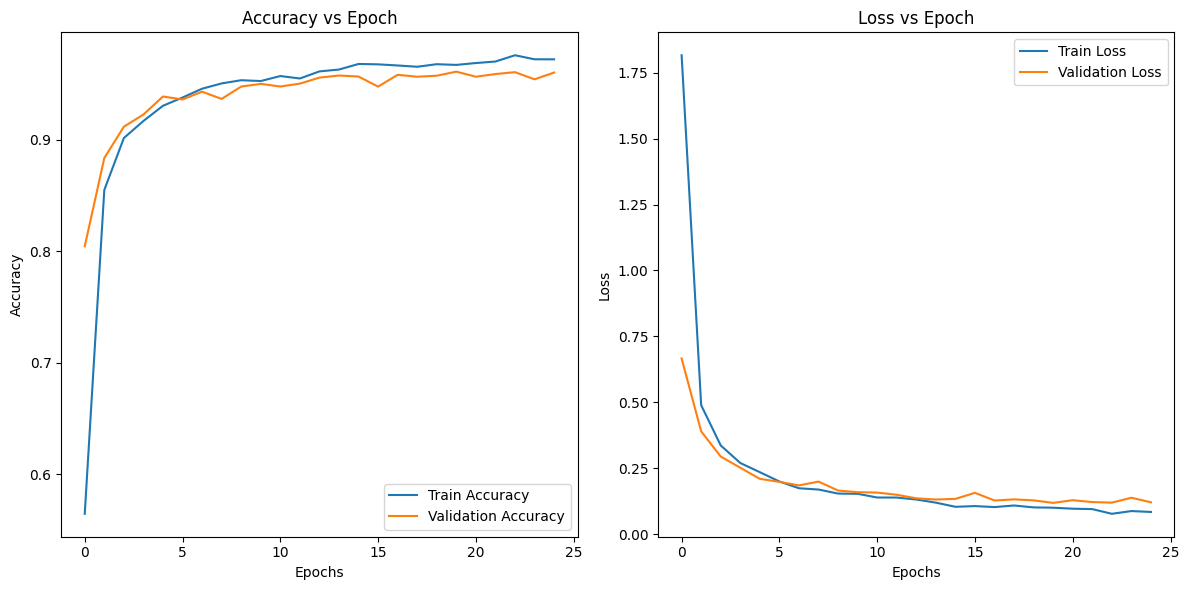

In [ ]:
# Accessing the history of accuracy and loss from the minimal model
train_loss_minimal = history_vgg_minimal.history['loss']
val_loss_minimal = history_vgg_minimal.history['val_loss']
train_accuracy_minimal = history_vgg_minimal.history['accuracy']
val_accuracy_minimal = history_vgg_minimal.history['val_accuracy']

# Plotting accuracy vs. loss
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_minimal, label='Train Accuracy')
plt.plot(val_accuracy_minimal, label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_minimal, label='Train Loss')
plt.plot(val_loss_minimal, label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


# MobileNet

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │        38,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,814 (12.47 MB)

 Trainable params: 38,950 (152.15 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


GFLOPs: 1.15
Epoch 1/30
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5614 - loss: 1.7967
Epoch 1: val_accuracy improved from -inf to 0.90223, saving model to /content/best_model_simple.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.5627 - loss: 1.7913 - val_accuracy: 0.9022 - val_loss: 0.3909 - learning_rate: 0.0010
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9176 - loss: 0.3385
Epoch 2: val_accuracy improved from 0.90223 to 0.92619, saving model to /content/best_model_simple.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.9176 - loss: 0.3384 - val_accuracy: 0.9262 - val_loss: 0.2611 - learning_rate: 0.0010
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9348 - loss: 0.2399
Epoch 3: val_accuracy improved from 0.92619 to 0.94656, saving model to /content/best_model_simple.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9348 - loss: 0.2399 - val_accuracy: 0.9466 - val_loss: 0.1962 - learnin

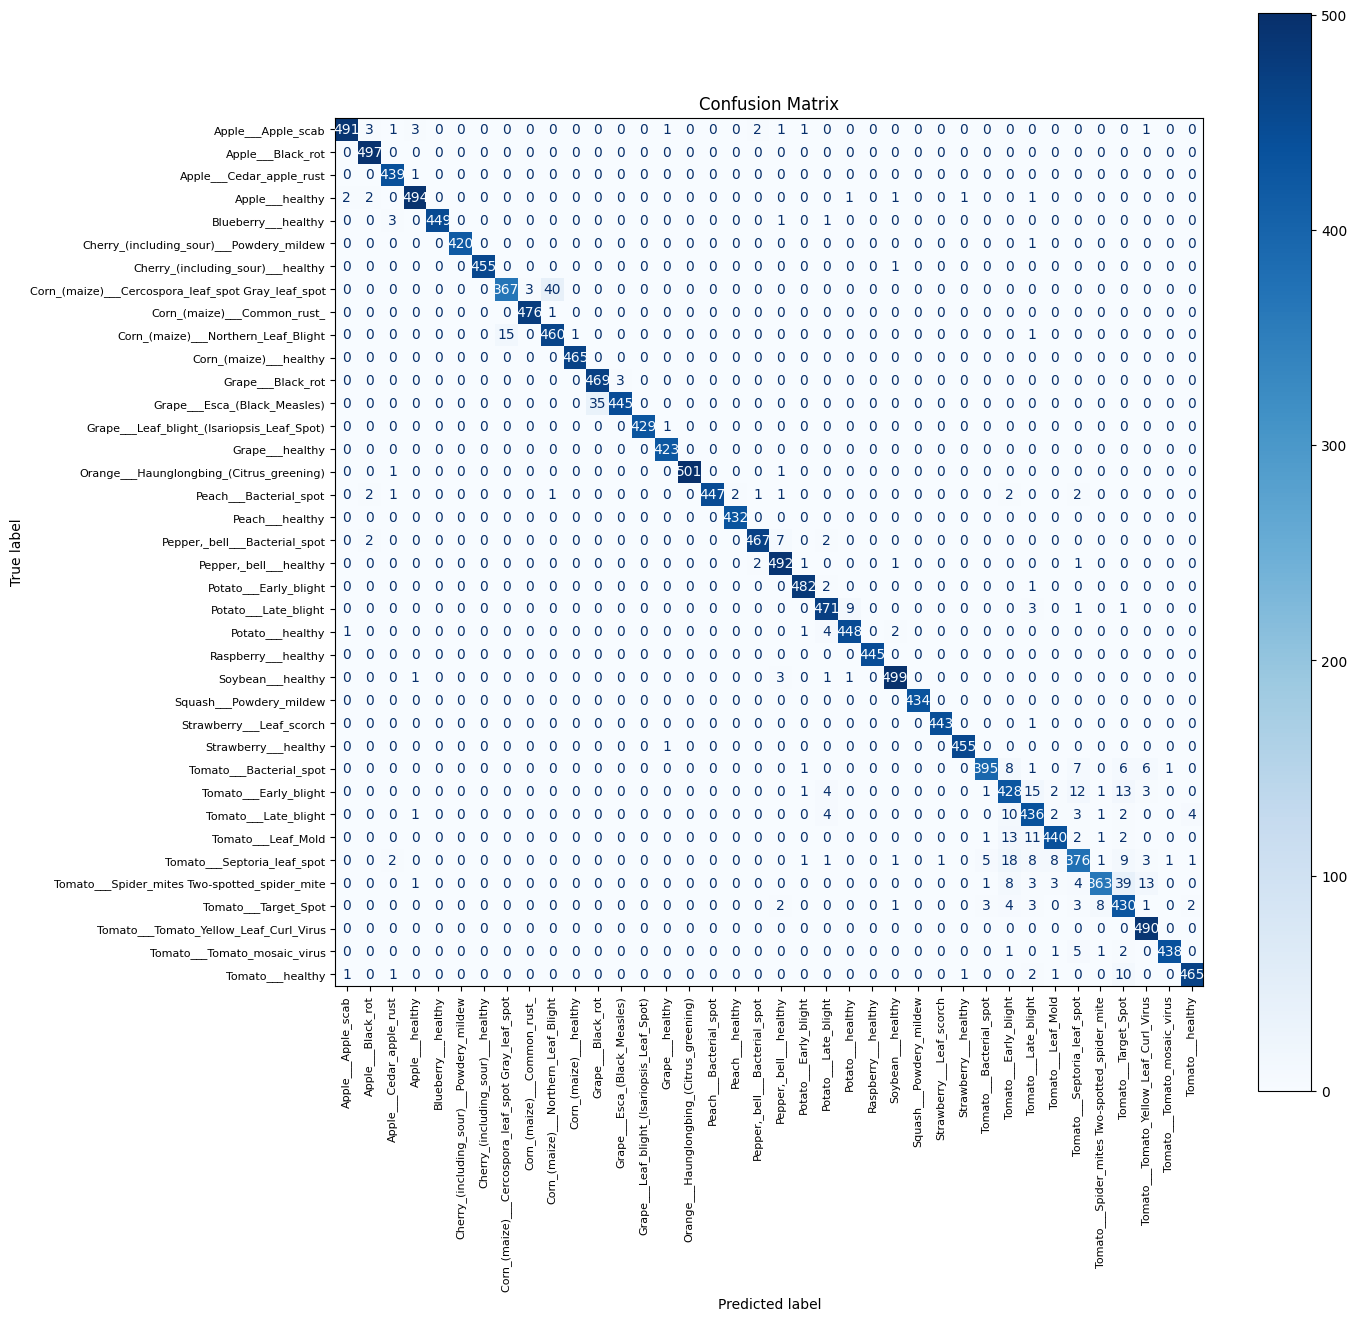

Classification Report for MobileNet Simple Model:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.97      0.98       504
                                 Apple___Black_rot       0.98      1.00      0.99       497
                          Apple___Cedar_apple_rust       0.98      1.00      0.99       440
                                   Apple___healthy       0.99      0.98      0.99       502
                               Blueberry___healthy       1.00      0.99      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.90      0.93       410
                       Corn_(maize)___Common_rust_       0.99      1.00      1.00       477
               Corn_(maize)_

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input

seed = SEED

# Load MobileNet base model
base_model_tf_simple = MobileNet(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model_tf_simple.trainable = False  # Freeze base

# Input + preprocessing
pt_simple = Input(shape=(224, 224, 3))
func_simple = Lambda(lambda x: tf.cast(x, tf.float32))(pt_simple)
x_simple = preprocess_input(func_simple)

# Add simplified classifier head
model_mobilenet_simple = base_model_tf_simple(x_simple, training=False)
model_mobilenet_simple = GlobalAveragePooling2D()(model_mobilenet_simple)

model_mobilenet_simple = Dense(38, activation='softmax')(model_mobilenet_simple)

# Define final model
model_main_mobilenet_simple = Model(inputs=pt_simple, outputs=model_mobilenet_simple)
model_main_mobilenet_simple.summary()

#  GFLOPs calculation

def get_flops(model, input_shape=(1, 224, 224, 3)):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(tf.TensorSpec(input_shape, model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)

    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

        flops = tf.compat.v1.profiler.profile(
            graph=graph,
            run_meta=run_meta,
            cmd='op',
            options=opts
        )
        return flops.total_float_ops

flops = get_flops(model_main_mobilenet_simple)
gflops = flops / 1e9
print(f"GFLOPs: {gflops:.2f}")

# Paths
path_train_simple = train_dir
path_valid_simple = val_dir

# Use preloaded datasets
train_simple = train_dataset_full
valid_simple = val_dataset_full

# Callbacks
es_simple = EarlyStopping(monitor='val_accuracy', verbose=True, patience=5, mode='auto')
mc_simple = ModelCheckpoint(filepath='/content/best_model_simple.keras', monitor='val_accuracy',
                            verbose=True, save_best_only=True)
lr_simple = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=True, min_lr=0.001)

# Compile
model_main_mobilenet_simple.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_mobilenet_simple = model_main_mobilenet_simple.fit(
    train_simple,
    validation_data=valid_simple,
    epochs=30,
    steps_per_epoch=300,
    verbose=True,
    callbacks=[mc_simple, es_simple, lr_simple]
)

# Get class names
class_names_simple = val_dataset_full.class_names

# Collect predictions
y_true_simple = []
y_pred_simple = []

for images, labels in val_dataset_full:
    preds = model_main_mobilenet_simple.predict(images)
    y_true_simple.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_simple.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm_flatten_simple = confusion_matrix(y_true_simple, y_pred_simple)
disp_flatten_simple = ConfusionMatrixDisplay(confusion_matrix=cm_flatten_simple, display_labels=class_names_simple)

fig, ax = plt.subplots(figsize=(14, 14))
disp_flatten_simple.plot(
    xticks_rotation=90,
    cmap='Blues',
    ax=ax
)

plt.title("Confusion Matrix")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# classification report

report_simple = classification_report(y_true_simple, y_pred_simple, target_names=class_names_simple)
print("Classification Report for MobileNet Simple Model:\n")
print(report_simple)



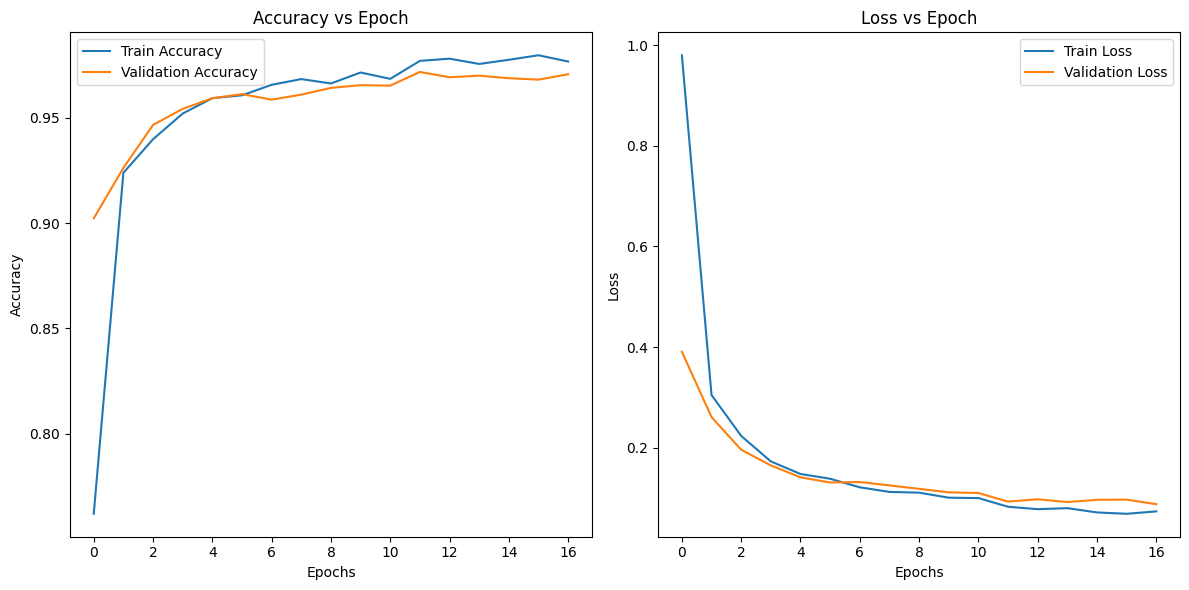

In [ ]:
# Accessing the history of accuracy and loss
train_loss = history_mobilenet_simple.history['loss']
val_loss = history_mobilenet_simple.history['val_loss']
train_accuracy = history_mobilenet_simple.history['accuracy']
val_accuracy = history_mobilenet_simple.history['val_accuracy']

# Plotting accuracy vs. loss
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Efficientnet_b0

In [ ]:
#Import libraries
# PyTorch

from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.optim import Adam
from torchsummary import summary
from ptflops import get_model_complexity_info
from torch.optim.lr_scheduler import ReduceLROnPlateau

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              SiLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 32, 112, 112]             288
          Identity-6         [-1, 32, 112, 112]               0
              SiLU-7         [-1, 32, 112, 112]               0
    BatchNormAct2d-8         [-1, 32, 112, 112]              64
          Identity-9         [-1, 32, 112, 112]               0
           Conv2d-10              [-1, 8, 1, 1]             264
             SiLU-11              [-1, 8, 1, 1]               0
           Conv2d-12             [-1, 32, 1, 1]             288
          Sigmoid-13             [-1, 32, 1, 1]               0
    SqueezeExcite-14

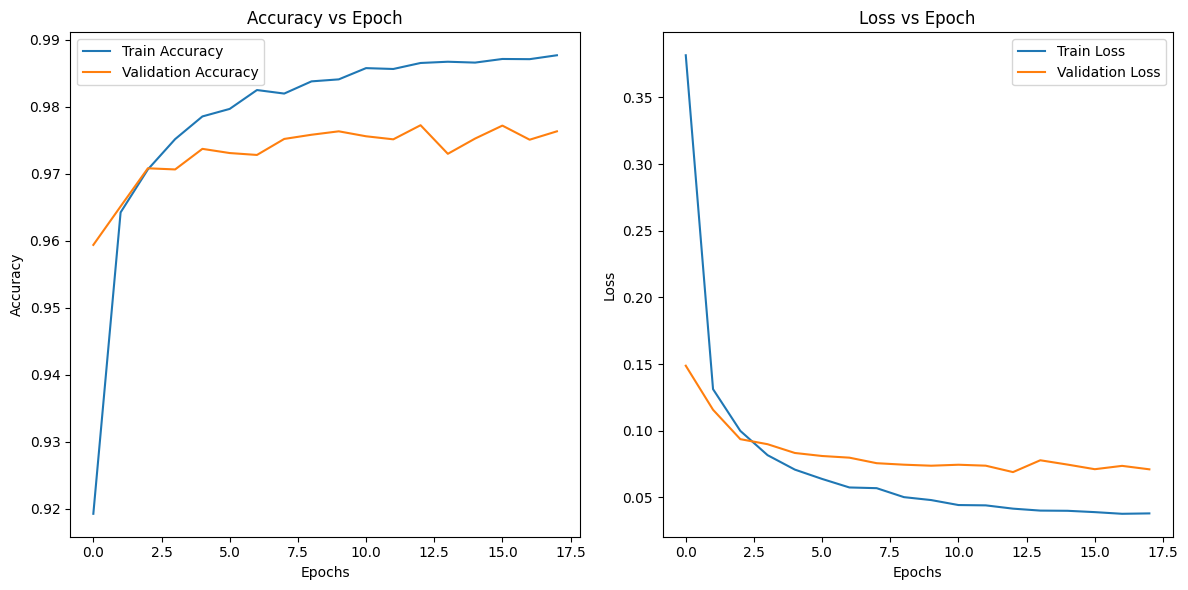

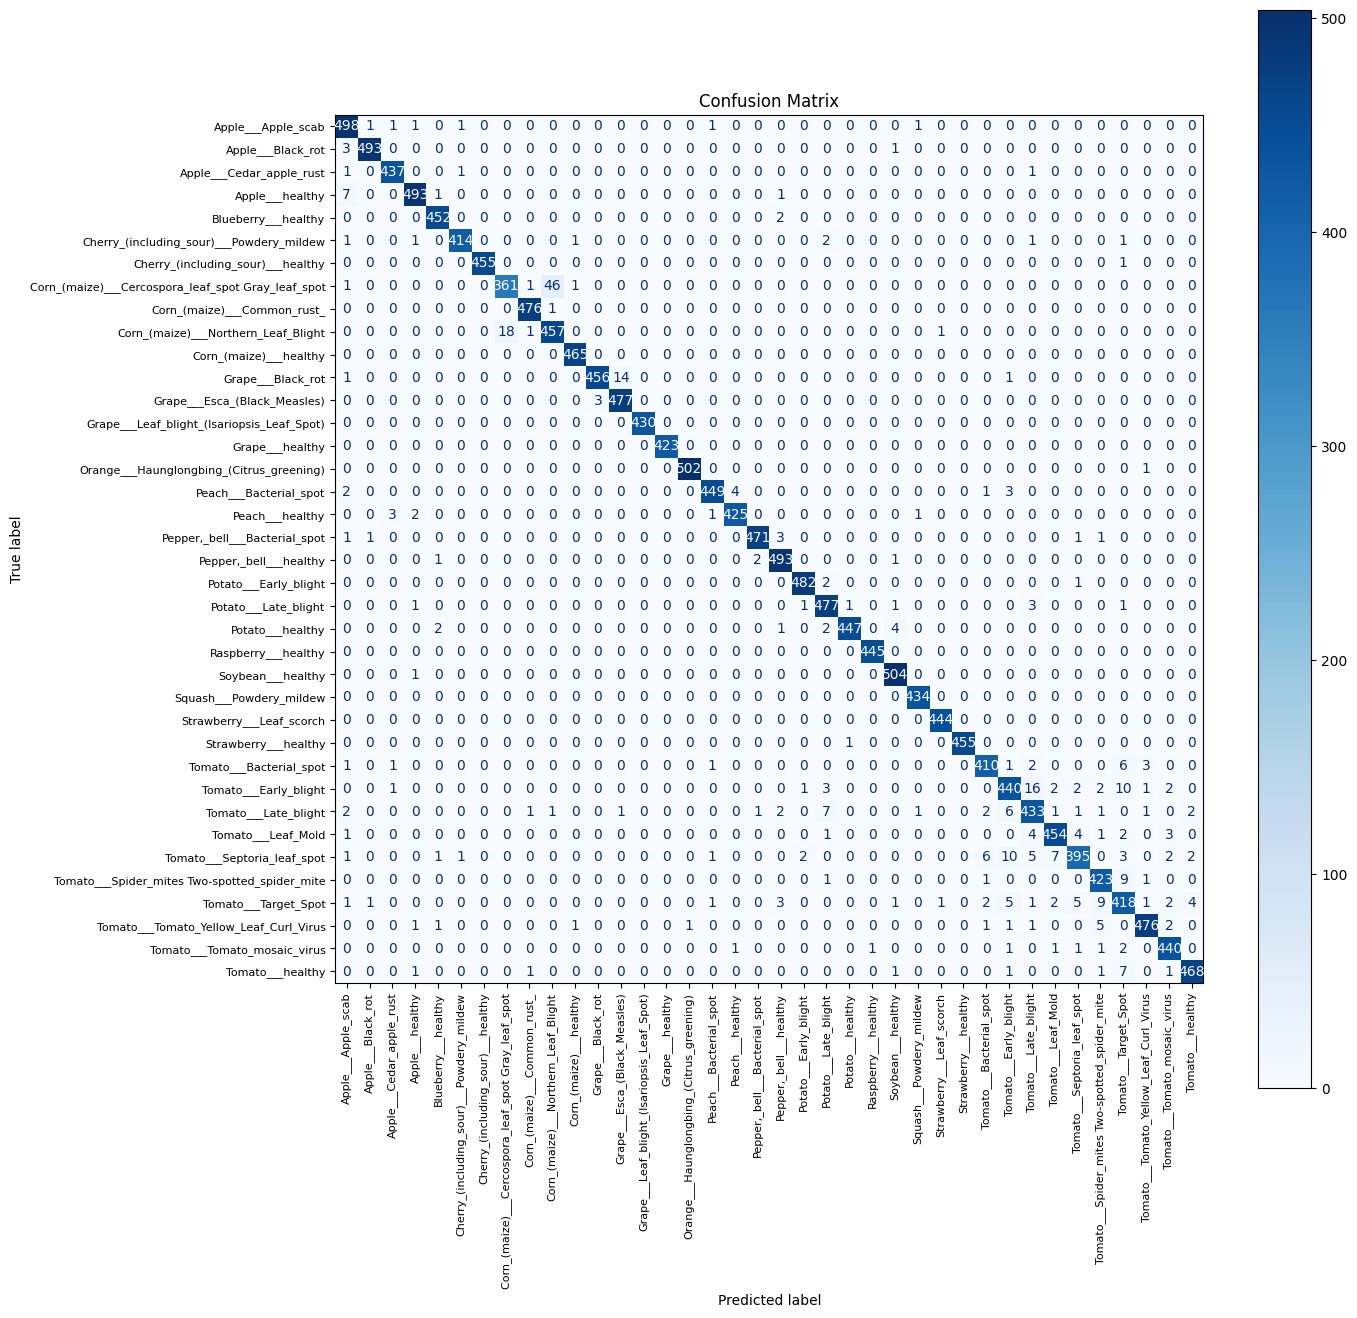

Classification Report for EfficientNet-B0:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.96      0.99      0.97       504
                                 Apple___Black_rot       0.99      0.99      0.99       497
                          Apple___Cedar_apple_rust       0.99      0.99      0.99       440
                                   Apple___healthy       0.98      0.98      0.98       502
                               Blueberry___healthy       0.99      1.00      0.99       454
          Cherry_(including_sour)___Powdery_mildew       0.99      0.98      0.99       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.88      0.92       410
                       Corn_(maize)___Common_rust_       0.99      1.00      0.99       477
               Corn_(maize)___North

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load EfficientNet model
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=38)

# Freeze base model
for param in model.parameters():
    param.requires_grad = False

# Set the classifier layer
model.classifier = nn.Linear(model.classifier.in_features, 38)

# Move model to device
model.to(device)

# Print model summary
summary(model, input_size=(3, 224, 224), device=str(device))

# FLOPs calculation

def print_gflops(model, input_res=(3, 224, 224)):
    macs, params = get_model_complexity_info(model, input_res, as_strings=False,
                                              print_per_layer_stat=False, verbose=False)
    mmacs = macs / 1e6  # Convert raw MACs to MMac
    gflops = mmacs * 2 / 1000  # Convert MMac to TensorFlow-style GFLOPs

    print(f"MMACs: {mmacs:.2f} MMac")
    print(f"TensorFlow-style GFLOPs: {gflops:.4f}")

# Call function
print_gflops(model)

# Set up data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
valid_dataset = ImageFolder(root=val_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=torch.Generator().manual_seed(SEED))
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, generator=torch.Generator().manual_seed(SEED))

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Scheduler and early stopping parameters
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, min_lr=1e-5, verbose=True)
best_val_acc = 0
patience = 5
patience_counter = 0
best_model_path = 'best_model.pth'

# History containers
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(valid_loader)
    val_accuracy = val_correct / val_total
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Scheduler step
    scheduler.step(val_accuracy)

    # Early stopping logic
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f'Best model saved with val_accuracy: {val_accuracy:.4f}')
    else:
        patience_counter += 1
        print(f'No improvement. Early stopping counter: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print('Early stopping triggered.')
            break

#Plot Training History
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#Confusion Matrix
model.load_state_dict(torch.load(best_model_path))  # load best weights
model.eval()

class_names = valid_dataset.classes
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(
    xticks_rotation=90,
    cmap='Blues',
    ax=ax
)

plt.title("Confusion Matrix")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# Classification Report

report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report for EfficientNet-B0:\n")
print(report)


# Mobilenetv3_large_100

Using device: cuda


model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
          Identity-2         [-1, 16, 112, 112]               0
         Hardswish-3         [-1, 16, 112, 112]               0
    BatchNormAct2d-4         [-1, 16, 112, 112]              32
            Conv2d-5         [-1, 16, 112, 112]             144
          Identity-6         [-1, 16, 112, 112]               0
              ReLU-7         [-1, 16, 112, 112]               0
    BatchNormAct2d-8         [-1, 16, 112, 112]              32
          Identity-9         [-1, 16, 112, 112]               0
         Identity-10         [-1, 16, 112, 112]               0
           Conv2d-11         [-1, 16, 112, 112]             256
         Identity-12         [-1, 16, 112, 112]               0
         Identity-13         [-1, 16, 112, 112]               0
   BatchNormAct2d-14         [-1, 16, 1

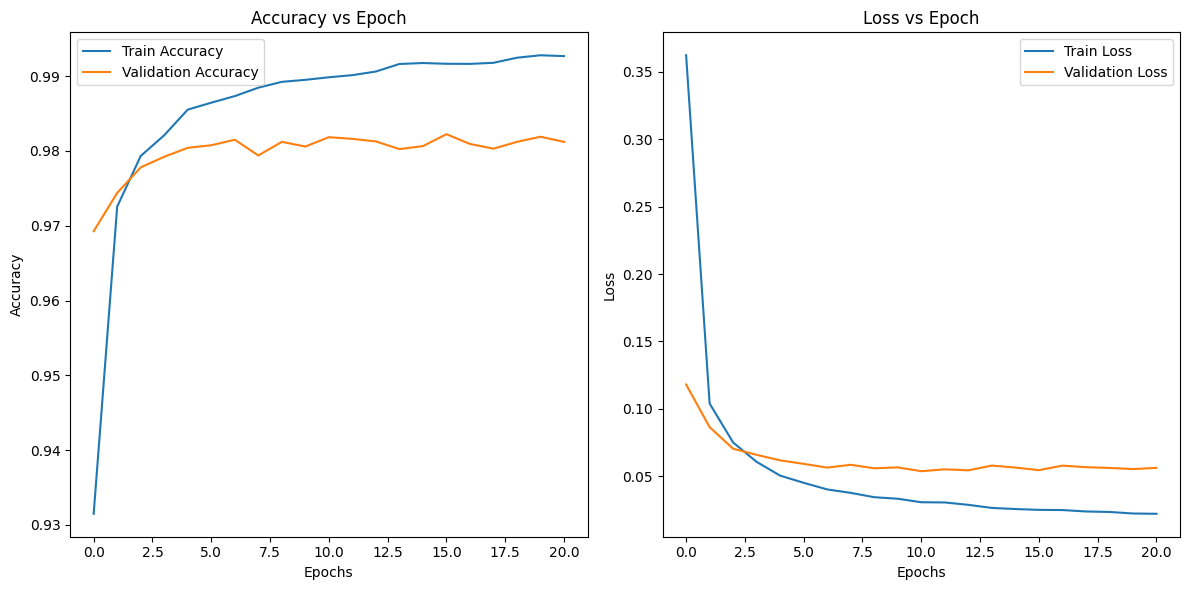

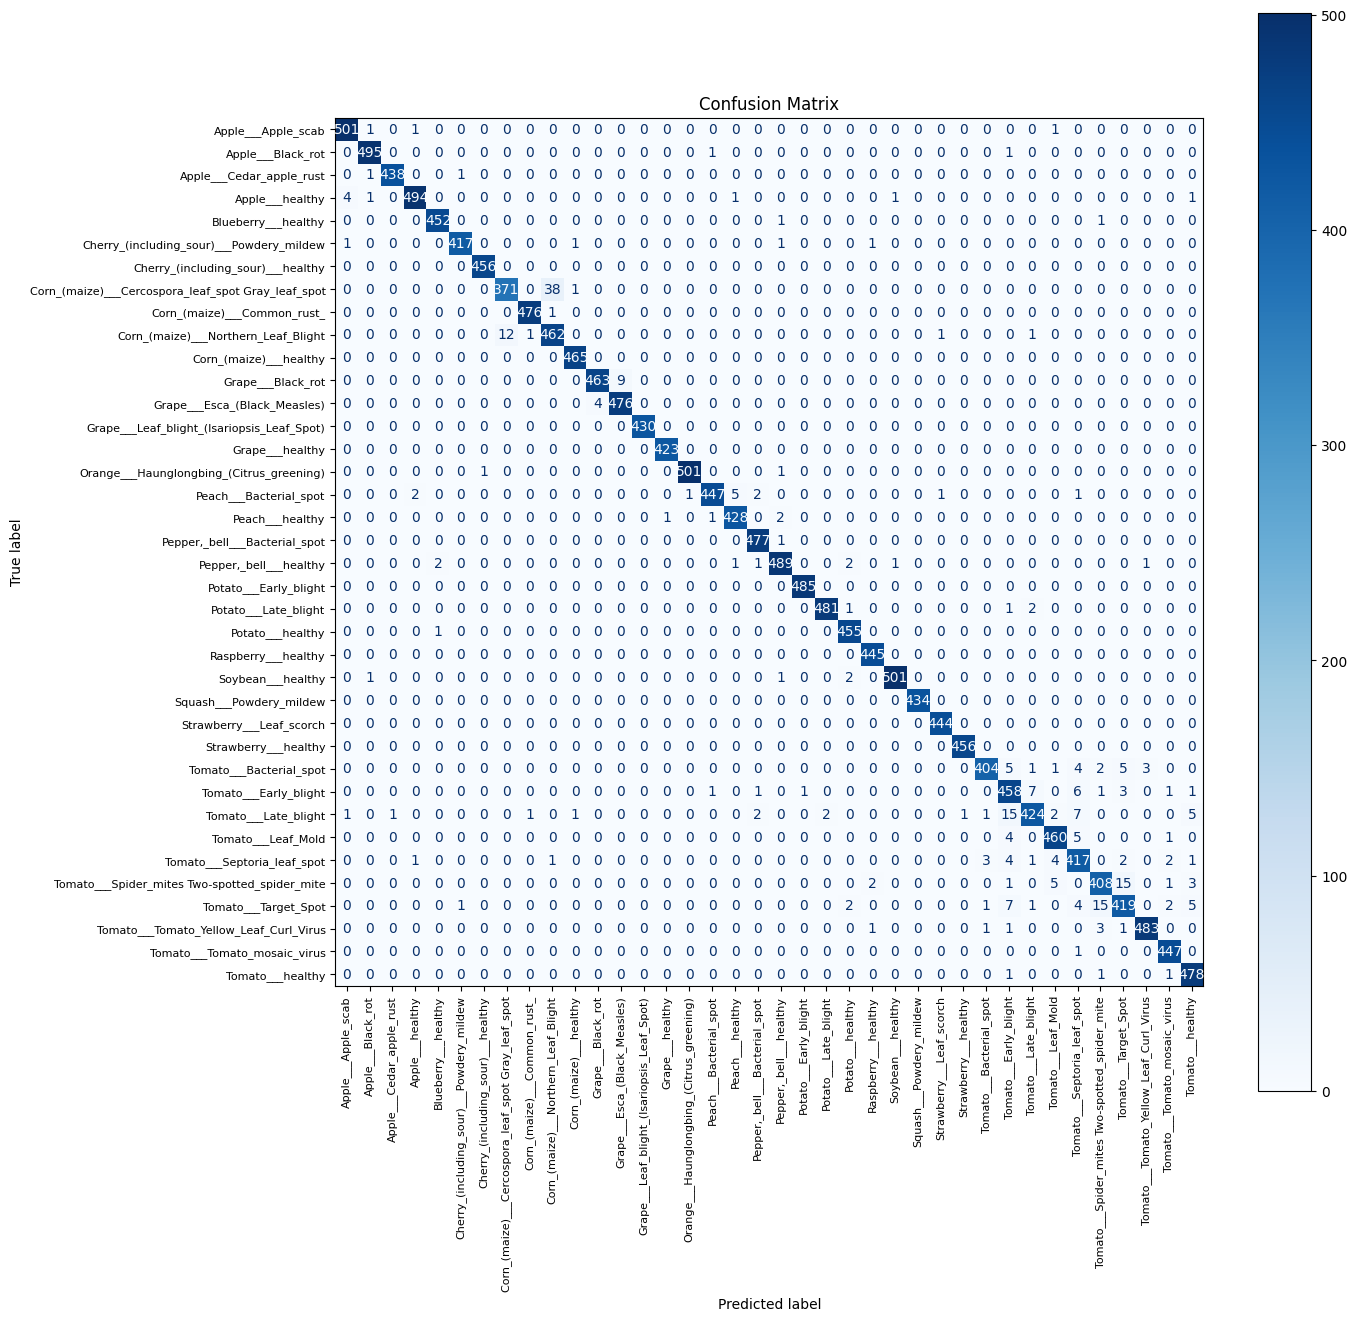

Classification Report for MobileNetV3-Large-100:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.99      0.99       504
                                 Apple___Black_rot       0.99      1.00      0.99       497
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       440
                                   Apple___healthy       0.99      0.98      0.99       502
                               Blueberry___healthy       0.99      1.00      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      0.99       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.90      0.94       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
               Corn_(maize)__

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load MobileNetV3 model
model = timm.create_model('mobilenetv3_large_100', pretrained=True, num_classes=38)

# Freeze base model
for param in model.parameters():
    param.requires_grad = False

# Set the classifier layer
model.classifier = nn.Linear(model.classifier.in_features, 38)

# Move model to device
model.to(device)

# Show parameter summary
from torchsummary import summary
summary(model, input_size=(3, 224, 224), device=str(device))

# GFLOPs calculation

def print_gflops(model, input_res=(3, 224, 224)):
    macs, params = get_model_complexity_info(model, input_res, as_strings=False,
                                              print_per_layer_stat=False, verbose=False)
    mmacs = macs / 1e6  # Convert raw MACs to MMac (million MACs)
    gflops = mmacs * 2 / 1000  # Now convert MMac to GFLOPs (TensorFlow style)

    print(f"MMACs: {mmacs:.2f} MMac")
    print(f"TensorFlow-style GFLOPs: {gflops:.4f}")


# Call the GFLOPs function
print_gflops(model)

# Set up data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
valid_dataset = ImageFolder(root=val_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=torch.Generator().manual_seed(SEED))
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, generator=torch.Generator().manual_seed(SEED))

# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, min_lr=1e-5, verbose=True)

# Early stopping
patience = 5
best_val_acc = 0
patience_counter = 0
best_model_path = 'best_mobilenetv3.pth'

# History containers
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(valid_loader)
    val_accuracy = val_correct / val_total
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Step scheduler
    scheduler.step(val_accuracy)

    # Early stopping logic
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f'Best model saved with val_accuracy: {val_accuracy:.4f}')
    else:
        patience_counter += 1
        print(f'No improvement. Early stopping counter: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Plot Training History
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
model.load_state_dict(torch.load(best_model_path))  # Load best saved model
model.eval()

# Get class names from validation dataset
class_names = valid_dataset.classes
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(
    xticks_rotation=90,
    cmap='Blues',
    ax=ax
)

plt.title("Confusion Matrix")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

#  Classification Report

report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report for MobileNetV3-Large-100:\n")
print(report)